## Use Segment Anything(SAM) Model to Get the Eye Masks

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from sam_funcs import *

In [2]:
# input the catalog number and get the image
catalog_num = input("Enter the Catalog Number: \n")
folder_path = '../data/' + catalog_num
image_name = get_image_names(folder_path, keyword='hef')
image_path = folder_path + '/' + image_name
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

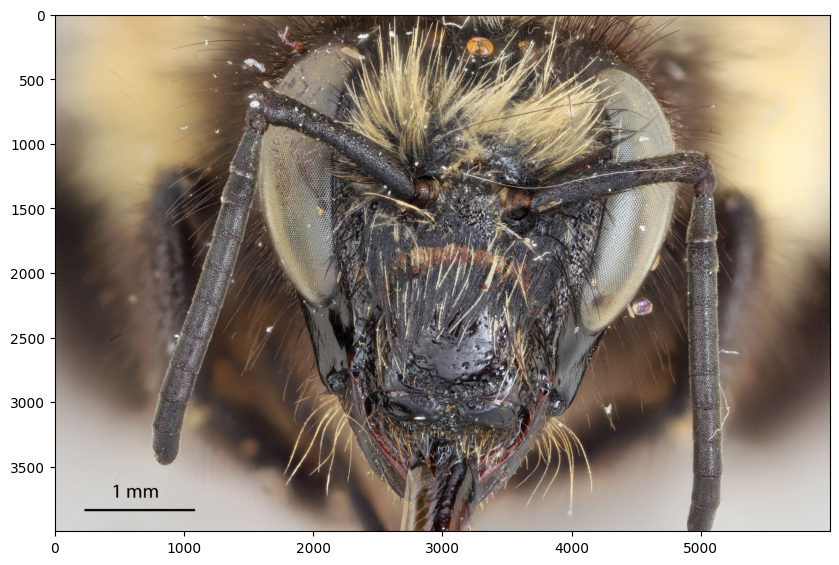

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [4]:
# import the SAM checkpoint
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [5]:
predictor.set_image(image)

## Specifying a specific object with a box and points

In [11]:
# define the prompt: box and points(positive and negative)
input_box = crop_box(image_path)
# specify how many points you want to use
input_point,input_label = get_seed_points(image_path,4)

In [12]:
# make the inference
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

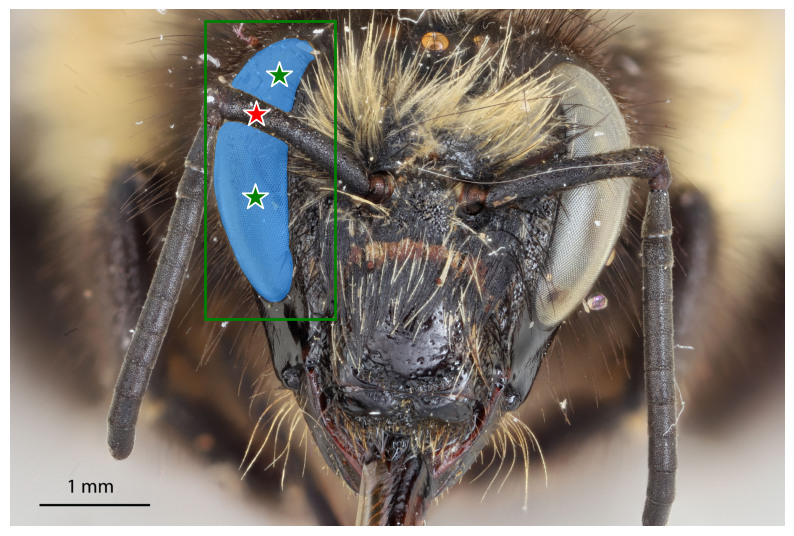

In [13]:
# visualize the mask and prompts in the original image
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

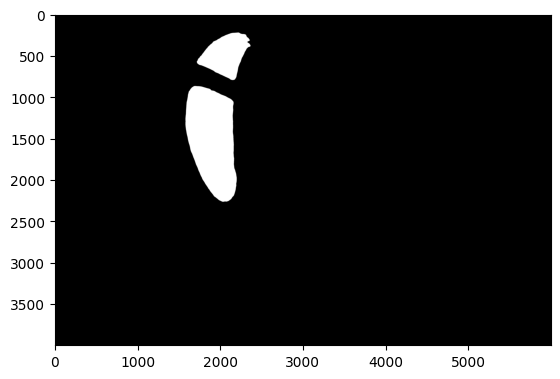

In [14]:
# check the mask in the binary image
eye_mask = masks.astype(np.uint8)
eye_mask = np.squeeze(eye_mask)
binary_mask_image = (eye_mask * 255).astype(np.uint8)
binary_mask_image = cv2.cvtColor(binary_mask_image, cv2.COLOR_BGR2RGB)

plt.imshow(binary_mask_image)
plt.axis('on')
plt.show()

In [15]:
# save the (left or right) eye mask to the data folder
which_eye = input("Which eye is this? (left or right): ")
if which_eye == 'left':
    mask_path = '../data/' + catalog_num + '/' + 'eye_mask_left.jpg'
elif which_eye == 'right':
    mask_path = '../data/' + catalog_num + '/' + 'eye_mask_right.jpg'

cv2.imwrite(mask_path, binary_mask_image)

True